In [2]:
import pandas as pd
import numpy as np
from sklearn import set_config
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt
import random
from collections import Counter

In [3]:
set_config(display='diagram')

### Canonizer sklearn svm pipeline

In [4]:
def plot_coefficients(coefs, feature_names, top_features):
    top_positive_coefficients = np.argsort(coefs)[-top_features:]
    top_negative_coefficients = np.argsort(coefs)[:top_features]
    top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
    # create plot
    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in coefs[top_coefficients]]
    plt.bar(np.arange(2 * top_features), coefs[top_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(0, 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
    plt.title("Meilleurs coefficients pour la classification binaire")
    plt.savefig('img/coefs_linear_svm.png')
    plt.show()

In [28]:
def canonizer(data, test_size=0.2, random_state=42, sampling=None, cross_validation=False, cv=5, kernel='rbf', nb_coef=20):
    
    df_results = pd.DataFrame()
    
    if cross_validation == True:
        
        pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
        
        #cv_results = cross_validate(pipe, data.drop(['canon'], axis=1), data['canon'], cv=cv, scoring='precision')
        cv_results = cross_val_score(pipe, data.drop(['gender'], axis=1), data['gender'], cv=cv, scoring=make_scorer(classification_report_with_accuracy_score))
        return pipe, cv_results
    
    else:
        if kernel == 'rbf':
            pipe = make_pipeline(StandardScaler(), Normalizer(), SVC(kernel=kernel, probability=True))
        else:
            pipe = make_pipeline(StandardScaler(), SVC(kernel=kernel, probability=True))
    

        X_train, X_test, y_train, y_test = train_test_split(data.drop(['gender'], axis=1), data['gender'], test_size=test_size, random_state=random_state)
        print('Original dataset shape {}'.format(Counter(y_train)))
        
    pipe.fit(X_train, y_train)
        
    report = metrics.classification_report(y_test, pipe.predict(X_test), output_dict=True)
    df_scores = pd.DataFrame(report).transpose()
    print(df_scores)

    _ = ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test)
                   
    df_results['metadata'] = y_test
    df_results['proba male'] = pipe.predict_proba(X_test)[:,0]
    df_results['proba female'] = pipe.predict_proba(X_test)[:,1]
    df_results['prediction']= pipe.predict(X_test)
        
    df_results['accord'] = [True if row['metadata'] == row['prediction'] else False for index, row in df_results.iterrows()]
    
    if kernel == 'linear':
        coefs = pipe.named_steps['svc'].coef_
        plot_coefficients(*coefs, data.columns, nb_coef)
        coef_names = data.columns
        return pipe, df_results, df_scores, coefs, coef_names

    return pipe, df_results, df_scores

In [6]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print(classification_report(y_true, y_pred))
    return accuracy_score(y_true, y_pred)

In [7]:
df_main = pd.read_csv(r'/home/crazyjeannot/Documents/master/M2/master_thesis/data/features.csv')
df_main.set_index("index", inplace = True)
df_main = df_main.replace(np.nan, 0)

In [10]:
df_metadata_corpus = pd.read_csv(r'metadata/corpus_gendered.csv')
df_metadata_corpus.set_index("doc_name", inplace = True)
df_metadata_corpus = df_metadata_corpus.replace(np.nan, 'male')

In [11]:
df_metadata_corpus.gender.value_counts()

male      2334
female     626
Name: gender, dtype: int64

In [12]:
def list_gender_opti(df_main, df_metadata_corpus):
    list_gender = []
    for elem in df_main.index:
        if elem in df_metadata_corpus.index:
            list_gender.append(df_metadata_corpus.loc[[elem]]['gender'][0])
            
    return list_gender

In [13]:
list_gender = list_gender_opti(df_main, df_metadata_corpus)

In [14]:
len(list_gender)

2960

In [15]:
df_main['gender'] = list_gender

In [16]:
df_main_gendered = df_main[(df_main['gender']== 'male')|(df_main['gender']== 'female')]

In [17]:
df_main_gendered.gender.value_counts(normalize=True)

male      0.788514
female    0.211486
Name: gender, dtype: float64

### Get balanced dataset with 

In [18]:
def ratio_truncate_df(df, ratio_canon):
    
    df_res = shuffle(df)
    ratio_temp = round(df_res['gender'].value_counts(normalize=True)[1],2)
    index_noncanon = df_res[df_res['gender']  == 'male'].index 
    i, j = 0, 20
        
    while ratio_temp < ratio_canon:
        df_res.drop(index_noncanon[i:j], inplace = True)
        i = j
        j+=20
        ratio_temp = round(df_res['gender'].value_counts(normalize=True)[1],2)

    return shuffle(df_res)

In [19]:
df_sizeopti_gendered = ratio_truncate_df(df_main_gendered, 0.4)

In [20]:
df_sizeopti_gendered.gender.value_counts(normalize=True)

male      0.603797
female    0.396203
Name: gender, dtype: float64

Original dataset shape Counter({'male': 759, 'female': 505})
              precision    recall  f1-score     support
female         0.931624  0.900826  0.915966  121.000000
male           0.939698  0.958974  0.949239  195.000000
accuracy       0.936709  0.936709  0.936709    0.936709
macro avg      0.935661  0.929900  0.932602  316.000000
weighted avg   0.936607  0.936709  0.936498  316.000000


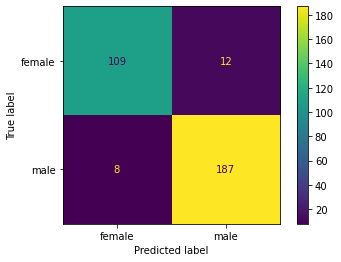

In [21]:
pipe, results, scores = canonizer(df_sizeopti_gendered)

In [23]:
df_unigram = df_sizeopti_gendered.iloc[:, 0:1000]

In [24]:
df_unigram['gender'] = df_sizeopti_gendered['gender']

Original dataset shape Counter({'male': 759, 'female': 505})
              precision    recall  f1-score     support
female         0.931624  0.900826  0.915966  121.000000
male           0.939698  0.958974  0.949239  195.000000
accuracy       0.936709  0.936709  0.936709    0.936709
macro avg      0.935661  0.929900  0.932602  316.000000
weighted avg   0.936607  0.936709  0.936498  316.000000


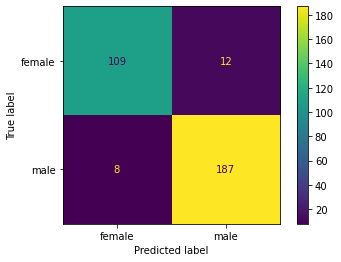

In [25]:
pipe, results, scores = canonizer(df_unigram)

Original dataset shape Counter({'male': 759, 'female': 505})
              precision    recall  f1-score     support
female         0.844262  0.851240  0.847737  121.000000
male           0.907216  0.902564  0.904884  195.000000
accuracy       0.882911  0.882911  0.882911    0.882911
macro avg      0.875739  0.876902  0.876310  316.000000
weighted avg   0.883111  0.882911  0.883002  316.000000


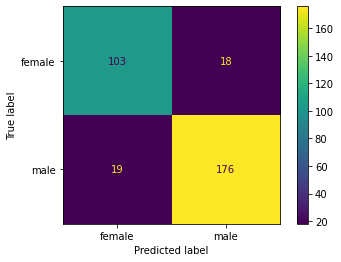

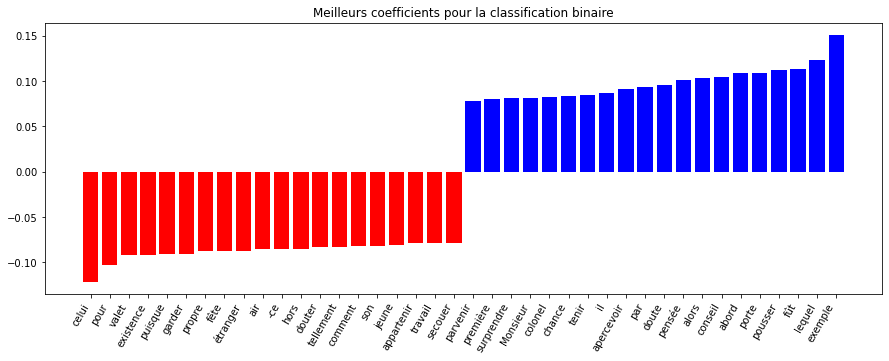

In [29]:
pipe, results, scores, coefs, coefs_name = canonizer(df_unigram, kernel='linear')

### RANDOM TEST

In [93]:
df_gendered_random = df_unigram.iloc[:, 0:1000]

In [99]:
df_gendered_random['gender'] = ['male' if random.randint(0, 1) else 'female' for i in range(len(df_gendered_random))]

Original dataset shape Counter({'female': 641, 'male': 617})
              precision    recall  f1-score    support
female         0.467066  0.513158  0.489028  152.00000
male           0.500000  0.453988  0.475884  163.00000
accuracy       0.482540  0.482540  0.482540    0.48254
macro avg      0.483533  0.483573  0.482456  315.00000
weighted avg   0.484108  0.482540  0.482227  315.00000


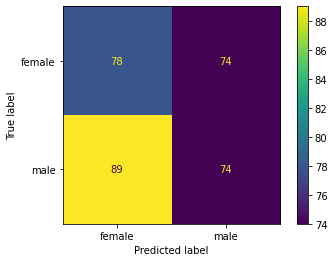

In [100]:
pipe, results, scores = canonizer(df_gendered_random)

### Cross-Validation

In [110]:
pipe, results = canonizer(df_unigram, cross_validation=True)

              precision    recall  f1-score   support

      female       0.92      0.82      0.86       125
        male       0.89      0.95      0.92       190

    accuracy                           0.90       315
   macro avg       0.90      0.88      0.89       315
weighted avg       0.90      0.90      0.90       315

              precision    recall  f1-score   support

      female       0.92      0.82      0.86       125
        male       0.89      0.95      0.92       190

    accuracy                           0.90       315
   macro avg       0.90      0.88      0.89       315
weighted avg       0.90      0.90      0.90       315

              precision    recall  f1-score   support

      female       0.90      0.80      0.85       126
        male       0.88      0.94      0.91       189

    accuracy                           0.89       315
   macro avg       0.89      0.87      0.88       315
weighted avg       0.89      0.89      0.88       315

              preci

In [111]:
sum(results)/len(results)

0.9008391466990193

In [109]:
sum(results)/len(results)

0.9116368415731474

### Get dataset with one novel per author

In [23]:
def onetxtoneauthor(df):
    liste_vu, index_vu = [], []
    df_onetxtoneauthor = pd.DataFrame(columns = df.columns)
    
    for index, row in df.iterrows():
        auteur = index.split("_")[1].replace('-',' ')
        if auteur not in liste_vu:
            df_onetxtoneauthor.loc[len(df_onetxtoneauthor.index)] = row
            liste_vu.append(auteur)
            index_vu.append(index)
    df_onetxtoneauthor.index = index_vu
    return df_onetxtoneauthor

In [37]:
df_unigrams_ones = onetxtoneauthor(df_unigram)

In [38]:
df_unigrams_ones.gender.value_counts(normalize=True)

male      0.706
female    0.294
Name: gender, dtype: float64

In [50]:
df_unigrams_ones_opti = ratio_truncate_df(df_unigrams_ones, 0.48)

In [51]:
df_unigrams_ones_opti.gender.value_counts(normalize=True)

male      0.51
female    0.49
Name: gender, dtype: float64

Original dataset shape Counter({'female': 122, 'male': 118})
              precision    recall  f1-score  support
female         0.807692  0.840000  0.823529    25.00
male           0.882353  0.857143  0.869565    35.00
accuracy       0.850000  0.850000  0.850000     0.85
macro avg      0.845023  0.848571  0.846547    60.00
weighted avg   0.851244  0.850000  0.850384    60.00


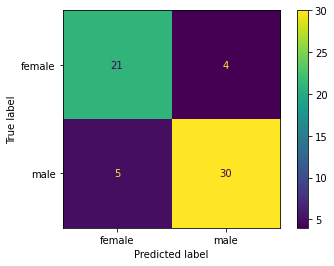

In [52]:
pipe, results, scores = canonizer(df_unigrams_ones_opti)

In [53]:
pipe, results = canonizer(df_unigrams_ones_opti, cross_validation=True)

              precision    recall  f1-score   support

      female       0.72      0.79      0.75        29
        male       0.79      0.71      0.75        31

    accuracy                           0.75        60
   macro avg       0.75      0.75      0.75        60
weighted avg       0.75      0.75      0.75        60

              precision    recall  f1-score   support

      female       0.91      0.69      0.78        29
        male       0.76      0.94      0.84        31

    accuracy                           0.82        60
   macro avg       0.84      0.81      0.81        60
weighted avg       0.83      0.82      0.81        60

              precision    recall  f1-score   support

      female       0.81      0.76      0.79        29
        male       0.79      0.84      0.81        31

    accuracy                           0.80        60
   macro avg       0.80      0.80      0.80        60
weighted avg       0.80      0.80      0.80        60

              preci

In [54]:
sum(results)/len(results)

0.77

### Get dataset with max 5 novels per author 

In [63]:
def max_five_txt_by_author(df, n):
    liste_vu, index_vu = [], []
    df_onetxtoneauthor = pd.DataFrame(columns = df.columns)
    
    for index, row in df.iterrows():
        auteur = index.split("_")[1].replace('-',' ')
        
        if Counter(liste_vu)[auteur] <= 5:          
            df_onetxtoneauthor.loc[len(df_onetxtoneauthor.index)] = row
            liste_vu.append(auteur)
            index_vu.append(index)
    df_onetxtoneauthor.index = index_vu
    return df_onetxtoneauthor

In [65]:
df_unigrams_fives = max_five_txt_by_author(df_unigram, 5)

In [66]:
df_unigrams_fives.gender.value_counts(normalize=True)

male      0.662791
female    0.337209
Name: gender, dtype: float64

Original dataset shape Counter({'male': 598, 'female': 296})
              precision    recall  f1-score     support
female         0.950820  0.716049  0.816901   81.000000
male           0.858896  0.979021  0.915033  143.000000
accuracy       0.883929  0.883929  0.883929    0.883929
macro avg      0.904858  0.847535  0.865967  224.000000
weighted avg   0.892136  0.883929  0.879548  224.000000


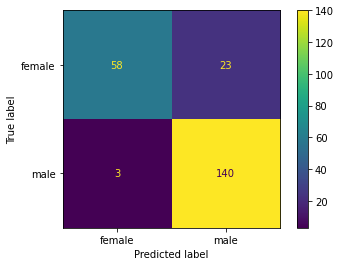

In [67]:
pipe, results, scores = canonizer(df_unigrams_fives)

In [68]:
pipe, results = canonizer(df_unigrams_fives, cross_validation=True)

              precision    recall  f1-score   support

      female       0.92      0.72      0.81        76
        male       0.87      0.97      0.92       148

    accuracy                           0.88       224
   macro avg       0.89      0.84      0.86       224
weighted avg       0.89      0.88      0.88       224

              precision    recall  f1-score   support

      female       0.87      0.76      0.81        76
        male       0.89      0.94      0.91       148

    accuracy                           0.88       224
   macro avg       0.88      0.85      0.86       224
weighted avg       0.88      0.88      0.88       224

              precision    recall  f1-score   support

      female       0.94      0.63      0.75        75
        male       0.84      0.98      0.90       149

    accuracy                           0.86       224
   macro avg       0.89      0.80      0.83       224
weighted avg       0.87      0.86      0.85       224

              preci

In [69]:
sum(results)/len(results)

0.8783632286995516